In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, expon, t, chi2, uniform, binom, poisson
from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.optimize import brentq
from sklearn.linear_model import LinearRegression
from datetime import datetime

from decimal import Decimal, ROUND_HALF_UP

plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('../Styles/stylesheet.mplstyle') 

In [23]:
# UTILITY FUNCTIONS
def round_four(x):
    d = Decimal(str(x)).quantize(Decimal('0.0001'), rounding=ROUND_HALF_UP)
    # Verwijder overbodige nullen, zonder wetenschappelijke notatie
    return format(d.normalize(), 'f')

# Schatten

## Puntschatters

In [26]:
sample = np.array([78, 72, 81, 74, 85, 71, 69, 84, 66, 76, 65, 79])
sample_size = sample.shape[0]
sample_mean = np.sum(sample) / sample_size
sample_var = np.sum((sample - sample_mean) ** 2) / (sample_size-1) 

print(f"Schatting van het gemiddelde $\\mu$ op basis van een steekproefgemiddelde $\\overline{{x}} = {sample_mean}$")
print(f"Schatting van de variantie $\\sigma^2$ op basis van de steekproefvariantie $s^2 = {sample_var}$")

sample_std = np.sqrt(sample_var)
print(f"Schatting van de standaardafwijking $\\sigma$ op basis van de steekproefstandaardafwijking $s = {sample_std}$")


Schatting van het gemiddelde $\mu$ op basis van een steekproefgemiddelde $\overline{x} = 75.0$
Schatting van de variantie $\sigma^2$ op basis van de steekproefvariantie $s^2 = 44.18181818181818$
Schatting van de standaardafwijking $\sigma$ op basis van de steekproefstandaardafwijking $s = 6.646940512883967$



# Student's $t$-verdeling

In [28]:
def betrouwbaarheidsinterval(sample_mean, sample_std, n, confidence=0.95):
    """Bereken het betrouwbaarheidsinterval voor een gegeven dataset."""
    t_waarde = t.ppf((1 + confidence) / 2, df=n-1)
    marge_fout = t_waarde * (sample_std / np.sqrt(n))
    return round(sample_mean - marge_fout), round(sample_mean + marge_fout)

def hypothesetoets(sample_mean, pop_mean, sample_std, n, alpha=0.02):
    """Voer een eenzijdige t-toets uit en geef terug of H0 verworpen moet worden."""
    t_stat = (sample_mean - pop_mean) / (sample_std / np.sqrt(n))
    kritieke_t = t.ppf(alpha, df=n-1)  # Eenzijdig, linkse grens
    return t_stat < kritieke_t, t_stat

def recordbreking(team_size, sample_mean, sample_std, alpha=0.05):
    """Bereken de waarde x waarvoor de kans op recordbreking 5% is."""
    team_mean = team_size * sample_mean
    team_std = np.sqrt(team_size) * sample_std
    kritieke_x = team_mean - norm.ppf(alpha) * team_std
    return round(kritieke_x)

# Gegeven waarden
sample_mean = 390  # ms
sample_std = 40  # ms
n = 18
pop_mean = 420  # ms
team_size = 6

# Uitvoeren van de berekeningen
bi_low, bi_high = betrouwbaarheidsinterval(sample_mean, sample_std, n)
reject_H0, t_stat = hypothesetoets(sample_mean, pop_mean, sample_std, n)
record_x = recordbreking(team_size, sample_mean, sample_std)

# Resultaten tonen
print(f"95%-betrouwbaarheidsinterval: ({bi_low}, {bi_high}) ms")
print(f"Hypothesetoets: t-statistiek = {t_stat:.2f}, Verwerp H0? {'Ja' if reject_H0 else 'Nee'}")
print(f"Waarde voor recordbreking bij 5% kans: {record_x} ms")

95%-betrouwbaarheidsinterval: (370, 410) ms
Hypothesetoets: t-statistiek = -3.18, Verwerp H0? Ja
Waarde voor recordbreking bij 5% kans: 2501 ms


# Clopper-Pearson intervallen

In [30]:
def solve_binom_cdf(n, k, target_prob, p_lower=1e-6, p_upper=0.5):
    """
    Solves for p such that BinomCDF(n, p, k) = target_prob.

    Parameters:
    - n: number of trials
    - k: number of successes (k or fewer)
    - target_prob: desired cumulative probability
    - p_lower, p_upper: search interval for p

    Returns:
    - p: estimated probability
    """
    func = lambda p: binom.cdf(k, n, p) - target_prob
    return brentq(func, p_lower, p_upper)
    
def clopper_pearson(k, n, alpha=0.05):
    """
    Computes the Clopper-Pearson exact confidence interval for a binomial proportion.

    Parameters:
    - k: number of successes
    - n: number of trials
    - alpha: significance level (default: 0.05 for 95% CI)

    Returns:
    - (lower_bound, upper_bound): tuple with lower and upper confidence limits
    """
    if not (0 <= k <= n):
        raise ValueError("$k$ moet een waarde hebben tussen $0$ en $n$.")
    if n == 0:
        return (0.0, 1.0)  # geen informatie

    # 1. Bereken de succeskans p1 zodanig dat P(X<=k)=binomcdf(n, p1, k)=\alpha/2
    p1 = solve_binom_cdf(n, k, alpha/2)

    # 2. Bereken de succeskans p2 zodanig dat P(X>=k)=alpha/2, oftewel dat P(X<=k-1)=binomcdf(n, p2, k-1)=1-\alpha/2
    p2 = solve_binom_cdf(n, k-1, 1-alpha/2)

    minimum = min(p1,p2)
    maximum = max(p1,p2)
    confidence_percentage = int(100 * (1 - alpha))
    print(f"Het ${confidence_percentage}\%$-betrouwbaarheidsinterval voor de succeskans $p$ op basis van de Clopper-Pearson methode is gelijk aan $[{minimum:.4f}, {maximum:.4f}]$.")

n = 365
k = 60
clopper_pearson(k, n, alpha=0.05)

Het $95\%$-betrouwbaarheidsinterval voor de succeskans $p$ op basis van de Clopper-Pearson methode is gelijk aan $[0.1278, 0.2065]$.


<>:43: SyntaxWarning: invalid escape sequence '\%'
<>:43: SyntaxWarning: invalid escape sequence '\%'
C:\Users\Admin\AppData\Local\Temp\ipykernel_9976\2103335875.py:43: SyntaxWarning: invalid escape sequence '\%'
  print(f"Het ${confidence_percentage}\%$-betrouwbaarheidsinterval voor de succeskans $p$ op basis van de Clopper-Pearson methode is gelijk aan $[{minimum:.4f}, {maximum:.4f}]$.")


# Lineaire regressie

In [32]:
def plot_linear_regression(X, Y):
    # Convert lists to numpy arrays

    X = np.array(X).reshape(-1, 1)
    Y = np.array(Y)

    # Calculate linear regression parameters
    model = LinearRegression()
    model.fit(X, Y)
    m = model.coef_[0] # slope
    b = model.intercept_ # intercept

    # Get the predictions
    Y_pred = model.predict(X)

    # Create scatter plot
    plt.scatter(X, Y, color='blue')
    
    # Plot regression line
    if b > 0:
        plt.plot(X, m * X + b, color='red', label=f"Regressielijn: Y={m:.4f}X+{b:.4f}")
    else:
        plt.plot(X, m * X + b, color='red', label=f"Regressielijn: Y={m:.4f}X{b:.4f}")

    # Label axes and add title
    plt.xlabel('$X$')
    plt.ylabel('$Y$')
    plt.title('Spreidingsdiagram')
    plt.legend()
    
    # Show plot
    plt.show()

def generate_latex_table(X, Y):
    # Start building the LaTeX table
    latex_code = (
        "\\begin{center}\n"
        "    \\begin{tabular}{c|cccccccccc}\n"
        "        \\toprule\n"
        "            \\textbf{$X$} & $" + "$ & $".join(map(str, X)) + "$ \\\\\n"
        "            \\textbf{$Y$} & $" + "$ & $".join(map(str, Y)) + "$ \\\\\n"
        "        \\bottomrule\n"
        "    \\end{tabular}\n"
        "\\end{center}"
    )
    
    return latex_code


def generate_latex_table_regression(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    
    # Compute XY, X^2, and Y^2
    XY = X * Y
    X_squared = X ** 2
    Y_squared = Y ** 2
    
    # Start building the LaTeX table
    latex_code = (
        "\\begin{center}\n"
        "\t\\begin{tabular}{ccccc}\n"
        "\t\t\\toprule\n"
        "\t\t\t$X$ & $Y$ & $XY$ & $X^2$ & $Y^2$ \\\\\n"
        "\t\t\\midrule\n"
    )
    
    # Populate table rows
    for x, y, xy, x2, y2 in zip(X, Y, XY, X_squared, Y_squared):
        latex_code += f"\t\t\t${round_four(x)}$ & ${round_four(y)}$ & ${round_four(xy)}$ & ${round_four(x2)}$ & ${round_four(y2)}$ \\\\\n"
    
    # Add final row with averages
    # Compute averages
    avg_X = np.mean(X)
    avg_Y = np.mean(Y)
    avg_XY = np.mean(XY)
    avg_X_squared = np.mean(X_squared)
    avg_Y_squared = np.mean(Y_squared)

    latex_code += (
        "\t\t\\midrule\n"
        f"$\t\t\t\\overline{{X}} = {avg_X:.4f}$ & "
        f"$\\overline{{Y}} = {avg_Y:.4f}$ & "
        f"$\\overline{{XY}} = {avg_XY:.4f}$ & "
        f"$\\overline{{X^2}} = {avg_X_squared:.4f}$ & "
        f"$\\overline{{Y^2}} = {avg_Y_squared:.4f}$ \\\\\n"
        "\t\t\\bottomrule\n"
        "\t\\end{tabular}\n"
    )    
    return latex_code

def pearson_correlation_latex(X, Y):
    X = np.array(X)
    Y = np.array(Y)
    
    # Compute necessary statistical values
    avg_X = np.mean(X)
    avg_Y = np.mean(Y)
    avg_XY = np.mean(X * Y)
    avg_X_squared = np.mean(X ** 2)
    avg_Y_squared = np.mean(Y ** 2)
    
    # Compute Pearson correlation coefficient
    numerator = avg_XY - (avg_X * avg_Y)
    denominator = np.sqrt((avg_X**2 - avg_X_squared) * (avg_Y**2 - avg_Y_squared))
    r = numerator / denominator
    
    # Generate LaTeX output
    latex_code = (
        "\\begin{align*}\n"
        "r &= \\frac{\\overline{X \\cdot Y} - \\overline{X} \\cdot \\overline{Y}}{\\sqrt{(\\overline{X}^2 - \\overline{X^2}) \\cdot (\\overline{Y}^2 - \\overline{Y^2})}} \\\\\n"
        f"&= \\frac{{{avg_XY:.3f} - {avg_X:.3f} \\cdot {avg_Y:.3f}}}{{\\sqrt{{({avg_X:.3f}^2 - {avg_X_squared:.3f}) \\cdot ({avg_Y:.3f}^{2} - {avg_Y_squared:.3f})}}}} \\\\\n"
        f"&= \\frac{{{numerator:.3f}}}{{{denominator:.3f}}} \\\\\n"
        f"&\\approx {r:.4f}.\n"
        "\\end{align*}"
    )
    
    return latex_code


\begin{center}
    \begin{tabular}{c|cccccccccc}
        \toprule
            \textbf{$X$} & $30$ & $50$ & $70$ & $90$ & $110$ & $130$ & $150$ & $170$ & $190$ & $210$ \\
            \textbf{$Y$} & $3.9$ & $3.5$ & $2.7$ & $6.1$ & $4.4$ & $5.6$ & $6.3$ & $4.4$ & $8.1$ & $7.5$ \\
        \bottomrule
    \end{tabular}
\end{center}


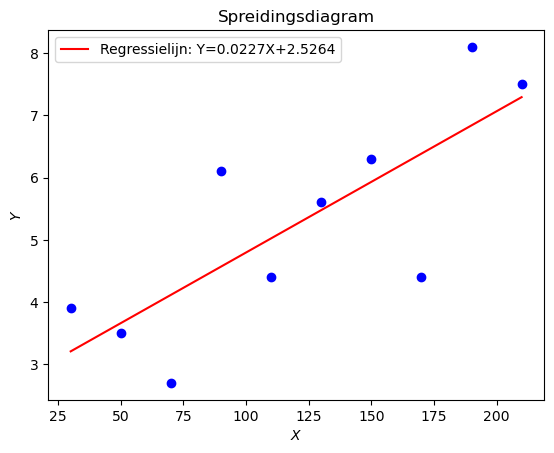

\begin{center}
	\begin{tabular}{ccccc}
		\toprule
			$X$ & $Y$ & $XY$ & $X^2$ & $Y^2$ \\
		\midrule
			$30$ & $3.9$ & $117$ & $900$ & $15.21$ \\
			$50$ & $3.5$ & $175$ & $2500$ & $12.25$ \\
			$70$ & $2.7$ & $189$ & $4900$ & $7.29$ \\
			$90$ & $6.1$ & $549$ & $8100$ & $37.21$ \\
			$110$ & $4.4$ & $484$ & $12100$ & $19.36$ \\
			$130$ & $5.6$ & $728$ & $16900$ & $31.36$ \\
			$150$ & $6.3$ & $945$ & $22500$ & $39.69$ \\
			$170$ & $4.4$ & $748$ & $28900$ & $19.36$ \\
			$190$ & $8.1$ & $1539$ & $36100$ & $65.61$ \\
			$210$ & $7.5$ & $1575$ & $44100$ & $56.25$ \\
		\midrule
$			\overline{X} = 120.0000$ & $\overline{Y} = 5.2500$ & $\overline{XY} = 704.9000$ & $\overline{X^2} = 17700.0000$ & $\overline{Y^2} = 30.3590$ \\
		\bottomrule
	\end{tabular}

\begin{align*}
r &= \frac{\overline{X \cdot Y} - \overline{X} \cdot \overline{Y}}{\sqrt{(\overline{X}^2 - \overline{X^2}) \cdot (\overline{Y}^2 - \overline{Y^2})}} \\
&= \frac{704.900 - 120.000 \cdot 5.250}{\sqrt{(120.000^2 - 17700.000) \c

In [33]:
## DRIVER CODE

# Give lists for X and Y
X = [30, 50, 70, 90, 110, 130, 150, 170, 190, 210]
Y = [3.9, 3.5, 2.7, 6.1, 4.4, 5.6, 6.3, 4.4, 8.1, 7.5]

# Generate LaTeX table for the question itself (horizontal)
latex_table = generate_latex_table(X, Y)
print(latex_table)

# Plot X and Y in a scatter plot
plot_linear_regression(X, Y)

# Generate LaTeX table for computing the regression line and the correlation coefficient
regression_table = generate_latex_table_regression(X, Y)
print(regression_table)

pearson = pearson_correlation_latex(X, Y)
print(pearson)

In [85]:
def generate_scatter_with_correlation(r: float, n: int = 100, seed: int = None):
    """
    Generate and plot a scatter plot of two variables with approximately the specified correlation coefficient.

    Parameters:
    - r (float): Desired correlation coefficient (-1 <= r <= 1).
    - n (int): Number of data points (default: 100).
    - seed (int): Optional random seed for reproducibility.
    """

    if not -1 <= r <= 1:
        raise ValueError("Correlation coefficient r must be between -1 and 1.")

    if seed is not None:
        np.random.seed(seed)

    # Generate two uncorrelated standard normal variables
    x = np.random.randn(n)
    y = r * x + np.sqrt(1 - r**2) * np.random.randn(n)

    # Plot
    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, color="blue", alpha=0.7)
    plt.title(f"Steekproefcorrelatiecoefficient $r(X,Y) \\approx {r}$")
    plt.xlabel("$X$")
    plt.ylabel("$Y$")
    # plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"../LaTeX/figures/correlation_r={r}.png")

    # Calculate actual correlation
    actual_r, _ = pearsonr(x, y)
    print(f"Actual Pearson correlation: {actual_r:.3f}")

for i in [-1 + _ * 0.2 for _ in range(20)]:
    generate_scatter_with_correlation(i, 20)

Actual Pearson correlation: -1.000
Actual Pearson correlation: -0.759
Actual Pearson correlation: -0.576
Actual Pearson correlation: -0.433
Actual Pearson correlation: -0.473
Actual Pearson correlation: -0.290
Actual Pearson correlation: 0.293
Actual Pearson correlation: 0.204
Actual Pearson correlation: 0.761
Actual Pearson correlation: 0.778
Actual Pearson correlation: 1.000


ValueError: Correlation coefficient r must be between -1 and 1.

# De $\chi^2$-verdeling

## Toepassing 1: de aanpassingstoets (goodness-of-fit test)

In [37]:
def generate_latex_table_chi2_aanpassing(categories, observed, expected):
    """
    Genereert een LaTeX-tabel met drie kolommen: Categorie, Observed, Expected.

    Parameters:
    - categories: lijst van labels of namen van wat gemeten wordt.
    - observed: lijst van geobserveerde waarden.
    - expected: lijst van verwachte waarden.

    Returns:
    - Een string met de LaTeX-tabelcode.
    """    
    header = f"""\\begin{{tabular}}{{lrr}}
    \t\\toprule
    \t\t\\textbf{{Categorie}} & \\textbf{{Observed}} & \\textbf{{Expected}} \\
    \t\\midrule
    """
    body = ""
    for cat, obs, exp in zip(categories, observed, expected):
        body += f"\t\t{cat} & ${obs}$ & ${round_four(exp)}$ \\\\\n"

    footer = f"\t\\bottomrule" + f"\n\\end{{tabular}}"
    return header + body + footer

def generate_latex_calculation_chi2_aanpassing(categories, observed, expected):
    """
    Genereert een LaTeX-berekening met Observed, Expected.

    Parameters:
    - categories: lijst van categorieen.
    - observed: lijst van geobserveerde waarden.
    - expected: lijst van verwachte waarden.

    Returns:
    - Een string met de LaTeX-berekeningscode.
    """
    header = f"\\begin{{align*}}"

    general_formula = " + ".join([f"\\frac{{(O_{{{cat}}} - E_{{{cat}}})^2}}{{E_{{{cat}}}}}" for cat in categories])
    filled_in_formula = " + ".join([f"\\frac{{({round_four(observed[i])} - {expected[i]:.4f})^2}}{{{expected[i]:.4f}}}" for i in range(len(observed))])
    result = np.sum((observed - expected) ** 2 / expected) 
    body = f"""
        \\chi^2 &= {general_formula}\\\\
               &= {filled_in_formula}\\\\
               &\\approx {result:.4f}
    """
    
    footer = f"\\end{{align*}}"
    return header + body + footer

def chi2_aanpassing(observed, expected):
    """
    Voert een chikwadraat aanpassingstoets uit.

    Parameters:
    - observed: list or array of observed frequencies
    - expected: list or array of expected frequencies (optional).
    
    Returns:
    - chi2_test_statistic: Chi-square statistic
    - p_value: corresponding p-value
    """
    observed = np.asarray(observed)
    expected = np.asarray(expected)

    chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)
    return chi2_stat, p_value



In [38]:
## DRIVER CODE ###

# Invoervariabelen
categories = np.array([0, 1, 2, 3])
observed = np.array([48, 24, 16, 12])
sum_observations = np.dot(categories, observed)
n_observations = np.sum(observed)
average_observation = sum_observations / n_observations
expected = np.array([n_observations * poisson.pmf(k=k, mu=1) for k in range(3)] + [n_observations * (1 - poisson.cdf(k=2, mu=1))])
# expected = [100 * percentage / 100 for percentage in [28, 36, 24, 12]]
num_estimated_parameters = 0

# Generate the LaTeX code for the solution
print(generate_latex_table_chi2_aanpassing(categories, observed, expected))
print(generate_latex_calculation_chi2_aanpassing(categories, observed, expected))

# Chi-kwadraat toetsingsgrootheid berekenen
chi2_stat, p_value = chisquare(observed, expected)

print(f"De toetsingsgrootheid $\\chi^2={chi2_stat:.4f}$ volgt onder de nulhypothese een $\\chi^2$-verdeling met df$={len(categories)}-1-{num_estimated_parameters}$ vrijheidsgraden.")
print("De $p$-waarde, oftewel de rechteroverschrijdingskans die hoort bij deze uitkomst van de toetsingsgrootheid is daarom gelijk aan")
print(f"""
    \\begin{{align*}}
        p = P(\\chi^2 > {chi2_stat:.4f}) &= \\chi^2\\text{{cdf}}(\\text{{lower}}={chi2_stat:.4f}; \\text{{upper}}=10^{{99}}; \\text{{df}}={len(categories)-1}) \\\\
                                         &\\approx {p_value:.4f}   
    \\end{{align*}}"""
)


\begin{tabular}{lrr}
    	\toprule
    		\textbf{Categorie} & \textbf{Observed} & \textbf{Expected} \
    	\midrule
    		0 & $48$ & $36.7879$ \\
		1 & $24$ & $36.7879$ \\
		2 & $16$ & $18.394$ \\
		3 & $12$ & $8.0301$ \\
	\bottomrule
\end{tabular}
\begin{align*}
        \chi^2 &= \frac{(O_{0} - E_{0})^2}{E_{0}} + \frac{(O_{1} - E_{1})^2}{E_{1}} + \frac{(O_{2} - E_{2})^2}{E_{2}} + \frac{(O_{3} - E_{3})^2}{E_{3}}\\
               &= \frac{(48 - 36.7879)^2}{36.7879} + \frac{(24 - 36.7879)^2}{36.7879} + \frac{(16 - 18.3940)^2}{18.3940} + \frac{(12 - 8.0301)^2}{8.0301}\\
               &\approx 10.1366
    \end{align*}
De toetsingsgrootheid $\chi^2=10.1366$ volgt onder de nulhypothese een $\chi^2$-verdeling met df$=4-1-0$ vrijheidsgraden.
De $p$-waarde, oftewel de rechteroverschrijdingskans die hoort bij deze uitkomst van de toetsingsgrootheid is daarom gelijk aan

    \begin{align*}
        p = P(\chi^2 > 10.1366) &= \chi^2\text{cdf}(\text{lower}=10.1366; \text{upper}=10^{99}; \text{df}=3

## Toepassing 2: de onafhankelijkheidstoets

In [40]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# Genereer LaTeX-tabellen
def dataframe_naar_latex(df, titel):
    latex = f"\\begin{{table}}[H]\n\\centering\n\\caption{{{titel}}}\n"
    latex += df.to_latex(escape=False)
    latex += "\\end{table}\n"
    return latex

def generate_latex_tables_chi2_onafhankelijkheid(matrix, row_names=None, col_names=None):
    # Transform the numpy array to a pandas DataFrame
    observed_df = pd.DataFrame(matrix,
                            index=row_names if row_names else [f"$R_{i+1}$" for i in range(matrix.shape[0])],
                            columns=col_names if col_names else [f"$C_{j+1}$" for j in range(matrix.shape[1])]
    )
    chi2, p, dof, expected = chi2_contingency(matrix, correction=False)

    print(chi2, p, dof, expected)
    expected_df = pd.DataFrame(expected, index=observed_df.index, columns=observed_df.columns)

    latex = [f"\\begin{{minipage}}{{0.45\\textwidth}}\n"]
    latex += dataframe_naar_latex(observed_df, "Geobserveerde frequenties")
    latex += f"\\end{{minipage}}\n\\hfill\n\\begin{{minipage}}{{0.45\\textwidth}}\n"
    latex += dataframe_naar_latex(expected_df, "Verwachte frequenties (expected)")
    latex += r"\end{minipage}"
    return latex

In [41]:
matrix = np.array([
    [143, 77],
    [97, 83]
])
print(generate_latex_tables_chi2_onafhankelijkheid(matrix, None, None))

5.092592592592593 0.02402824411732132 1 [[132.  88.]
 [108.  72.]]
['\\begin{minipage}{0.45\\textwidth}\n', '\\', 'b', 'e', 'g', 'i', 'n', '{', 't', 'a', 'b', 'l', 'e', '}', '[', 'H', ']', '\n', '\\', 'c', 'e', 'n', 't', 'e', 'r', 'i', 'n', 'g', '\n', '\\', 'c', 'a', 'p', 't', 'i', 'o', 'n', '{', 'G', 'e', 'o', 'b', 's', 'e', 'r', 'v', 'e', 'e', 'r', 'd', 'e', ' ', 'f', 'r', 'e', 'q', 'u', 'e', 'n', 't', 'i', 'e', 's', '}', '\n', '\\', 'b', 'e', 'g', 'i', 'n', '{', 't', 'a', 'b', 'u', 'l', 'a', 'r', '}', '{', 'l', 'r', 'r', '}', '\n', '\\', 't', 'o', 'p', 'r', 'u', 'l', 'e', '\n', ' ', '&', ' ', '$', 'C', '_', '1', '$', ' ', '&', ' ', '$', 'C', '_', '2', '$', ' ', '\\', '\\', '\n', '\\', 'm', 'i', 'd', 'r', 'u', 'l', 'e', '\n', '$', 'R', '_', '1', '$', ' ', '&', ' ', '1', '4', '3', ' ', '&', ' ', '7', '7', ' ', '\\', '\\', '\n', '$', 'R', '_', '2', '$', ' ', '&', ' ', '9', '7', ' ', '&', ' ', '8', '3', ' ', '\\', '\\', '\n', '\\', 'b', 'o', 't', 't', 'o', 'm', 'r', 'u', 'l', 'e', '\n',